In [3]:
# Install all needed packages from PyG:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-geometric -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html

!pip install -q path
!pip install torchmetrics

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 235kB 26.3MB/s 


In [4]:
import torch
import sys

from torch_geometric.datasets import ModelNet
import torch_geometric.transforms as T
from torch_geometric.transforms import SamplePoints

import numpy as np
import matplotlib.pyplot as plt

import os
from path import Path

import collections

##Import drive folder

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

### Import Datasets

In [6]:
# Import ModelNet10 dataset from PyG
dataset = ModelNet(root='/content/drive/MyDrive/Dataset/ModelNet', name="10", train=True, pre_transform=T.SamplePoints(num=1024)) #train dataset
test_dataset = ModelNet(root='/content/drive/MyDrive/Dataset/ModelNet', name="10", train=False, pre_transform=T.SamplePoints(num=1024))  #test dataset

Extracting /content/drive/MyDrive/Dataset/ModelNet/ModelNet10.zip
Processing...
Done!


In [7]:
print('Datasets info:')
print('--------------')
print('Train dataset size: ', len(dataset))
print('Test dataset size: ', len(test_dataset))
print('Number of classes: ', dataset.num_classes) 

Datasets info:
--------------
Train dataset size:  3991
Test dataset size:  908
Number of classes:  10


### Spliting training dataset

We split the training dataset into training and validation (80% for training and 20% for validation)

In [8]:
torch.manual_seed(0)
_, perm = dataset.shuffle(return_perm=True)      #Shuffle before splitting data  (random split)

In [9]:
#Create two text files with the indices of the training and validation data
train = open("/content/drive/MyDrive/Dataset/train_split.txt", 'w')
val = open("/content/drive/MyDrive/Dataset/val_split.txt", 'w')

#Split the tensor of indices in training and validation
train_split, val_split= perm.split(round(len(perm)*0.8))

i=0
for i in range(len(train_split)):
  train.writelines(str(train_split[i].item()) + "\n")
for i in range(len(val_split)):
  val.writelines(str(val_split[i].item())+ "\n")

train.close()
val.close()

In [10]:
train_dataset = dataset[train_split]
val_dataset = dataset[val_split]

print('Datasets info:')
print('--------------')
print('Train dataset size: ', len(train_dataset))
print('Val dataset size: ', len(val_dataset))
print('Test dataset size: ', len(test_dataset)) 

Datasets info:
--------------
Train dataset size:  3193
Val dataset size:  798
Test dataset size:  908


### Histogram of class frequencies

In [12]:
#Classes in the dataset Modelnet10
path = Path('/content/drive/MyDrive/Dataset/ModelNet/raw')
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

In [13]:
#Function to visualize classes frequency (histograms)
def plot_histogram(x):
  labels = [] #initilize label list
  fig = plt.figure(figsize=(10, 5))
  ax = plt.subplot()
  for iter in range(len(x)): #iterations over all elements
      element = x[iter]
      labels.append(x.raw_file_names[element.y]) #save the current element label
  histogram = collections.Counter(labels) #Counting label frequency
  norm_histogram = {k: v / sum(histogram.values()) for k, v in histogram.items()}
  ax.bar(histogram.keys(), norm_histogram.values(), 0.2, color='b',)

  if x == train_dataset:
    ax.set(title='Frecuency of classes (Training dataset)', xlabel='Classes', ylabel='Normalized Frequency')
  
  elif x == val_dataset:
    ax.set(title='Frecuency of classes (Validation dataset)', xlabel='Classes', ylabel='Normalized Frequency')

  else:
    ax.set(title='Frecuency of classes (Testing dataset)', xlabel='Classes', ylabel='Normalized Frequency')
  
  plt.show()  
  
  return histogram, norm_histogram

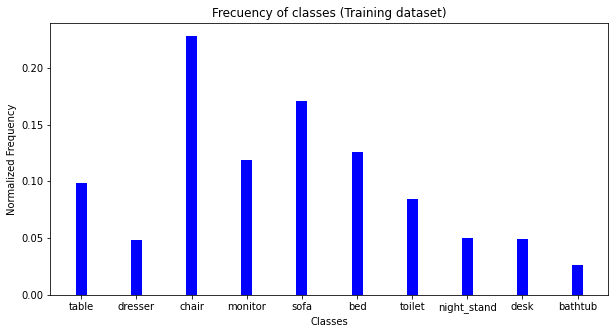

Normalized Class frequency (train):  {'table': 0.09896648919511432, 'dresser': 0.04791731913560914, 'chair': 0.22799874725963043, 'monitor': 0.11838396492326965, 'sofa': 0.17068587535233323, 'bed': 0.1255872220482305, 'toilet': 0.08455997494519261, 'night_stand': 0.05042279987472596, 'desk': 0.049170059505167556, 'bathtub': 0.02630754776072659}
Class frequency (train):  Counter({'chair': 728, 'sofa': 545, 'bed': 401, 'monitor': 378, 'table': 316, 'toilet': 270, 'night_stand': 161, 'desk': 157, 'dresser': 153, 'bathtub': 84})


In [14]:
#Train dataset
histogram, norm_histogram = plot_histogram(train_dataset)
print('Normalized Class frequency (train): ', norm_histogram)
print('Class frequency (train): ', histogram)

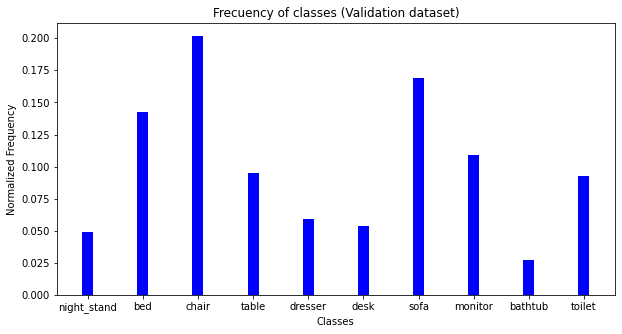

Normalized Class frequency (val):  {'night_stand': 0.04887218045112782, 'bed': 0.14285714285714285, 'chair': 0.20175438596491227, 'table': 0.09523809523809523, 'dresser': 0.05889724310776942, 'desk': 0.05388471177944862, 'sofa': 0.16917293233082706, 'monitor': 0.10902255639097744, 'bathtub': 0.02756892230576441, 'toilet': 0.09273182957393483}
Class frequency (val):  Counter({'chair': 161, 'sofa': 135, 'bed': 114, 'monitor': 87, 'table': 76, 'toilet': 74, 'dresser': 47, 'desk': 43, 'night_stand': 39, 'bathtub': 22})


In [15]:
#Val dataset
histogram, norm_histogram = plot_histogram(val_dataset)
print('Normalized Class frequency (val): ', norm_histogram)
print('Class frequency (val): ', histogram)

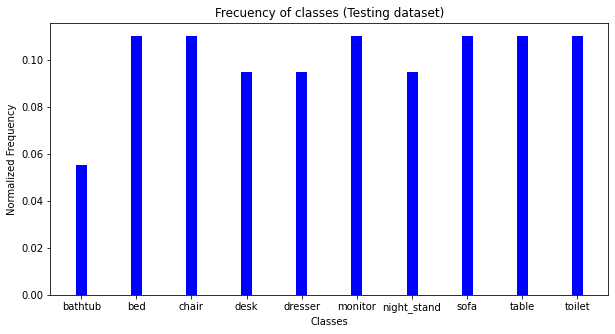

Normalized Class frequency (test):  {'bathtub': 0.05506607929515418, 'bed': 0.11013215859030837, 'chair': 0.11013215859030837, 'desk': 0.0947136563876652, 'dresser': 0.0947136563876652, 'monitor': 0.11013215859030837, 'night_stand': 0.0947136563876652, 'sofa': 0.11013215859030837, 'table': 0.11013215859030837, 'toilet': 0.11013215859030837}
Class frequency (test):  Counter({'bed': 100, 'chair': 100, 'monitor': 100, 'sofa': 100, 'table': 100, 'toilet': 100, 'desk': 86, 'dresser': 86, 'night_stand': 86, 'bathtub': 50})


In [16]:
#Test dataset
histogram, norm_histogram = plot_histogram(test_dataset)
print('Normalized Class frequency (test): ', norm_histogram)
print('Class frequency (test): ', histogram)

### Data visualization